In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from time import time
import coremltools
%matplotlib notebook

<IPython.core.display.Javascript object>


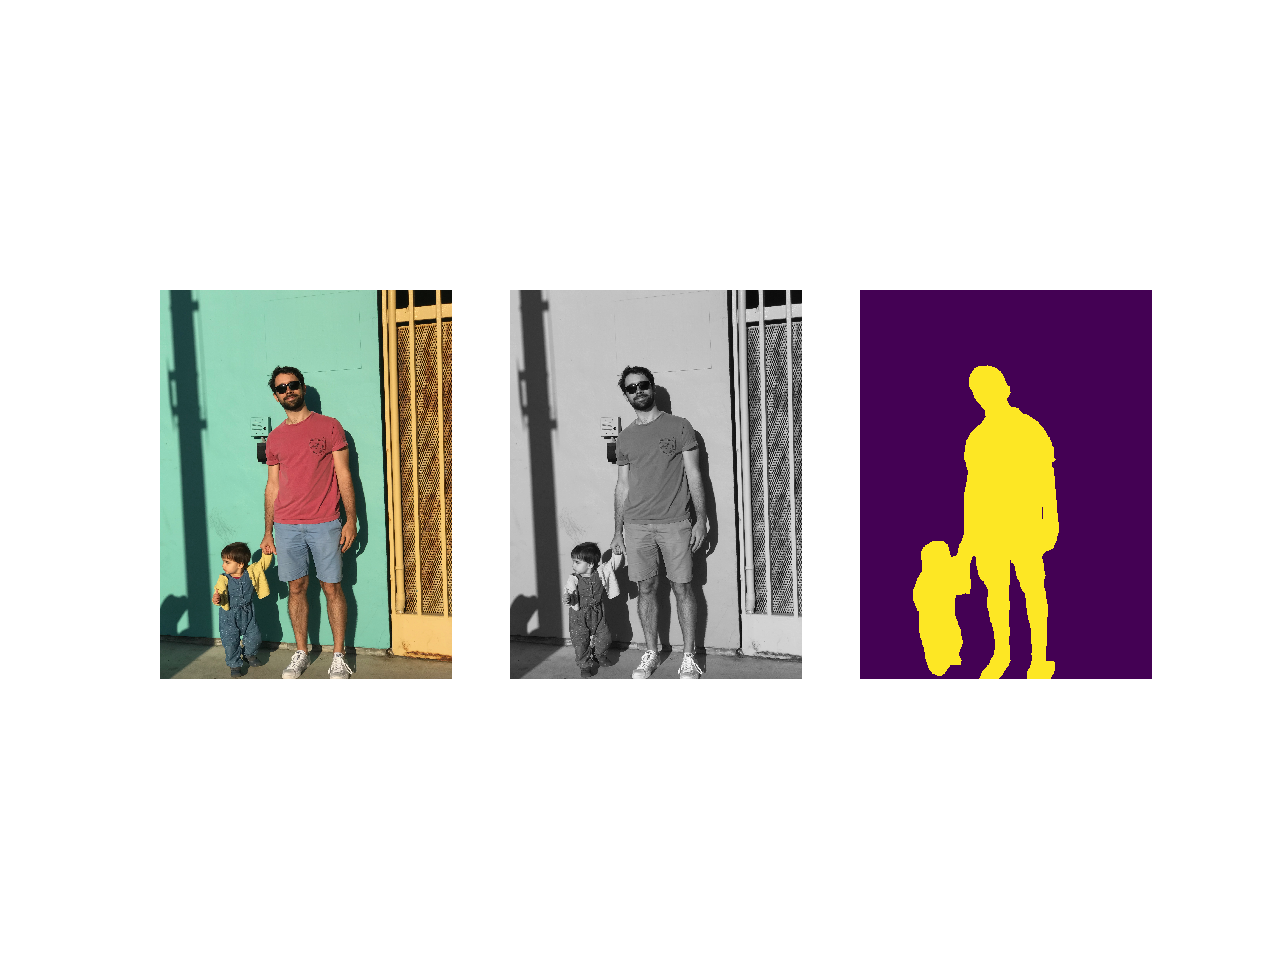

In [7]:
# Load the image
img_rgb = Image.open('../../../samples/person_matthieu.jpg')
img_y = img_rgb.convert('L')

# Load the model and it's specs
model = coremltools.models.MLModel('../../../models/DeepLab.mlmodel')
input_width = model.get_spec().description.input[0].type.imageType.width
input_height = model.get_spec().description.input[0].type.imageType.height

# Resize the image to fit model's input size
small_img = img_rgb.resize((input_width, input_height), Image.BILINEAR)

# Predict the classes
y = model.predict({"image": small_img}, usesCPUOnly=False)
small_pred = y['scores']

# Resize the prediction to input image size
pred = small_pred.resize((img_rgb.width, img_rgb.height), PIL.Image.NEAREST)

# Plot
f, ax = plt.subplots(1,3)
ax[0].imshow(img_rgb)
ax[1].imshow(img_y, cmap='gray')
ax[2].imshow(pred)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.show()

In [8]:
import cv2

<IPython.core.display.Javascript object>


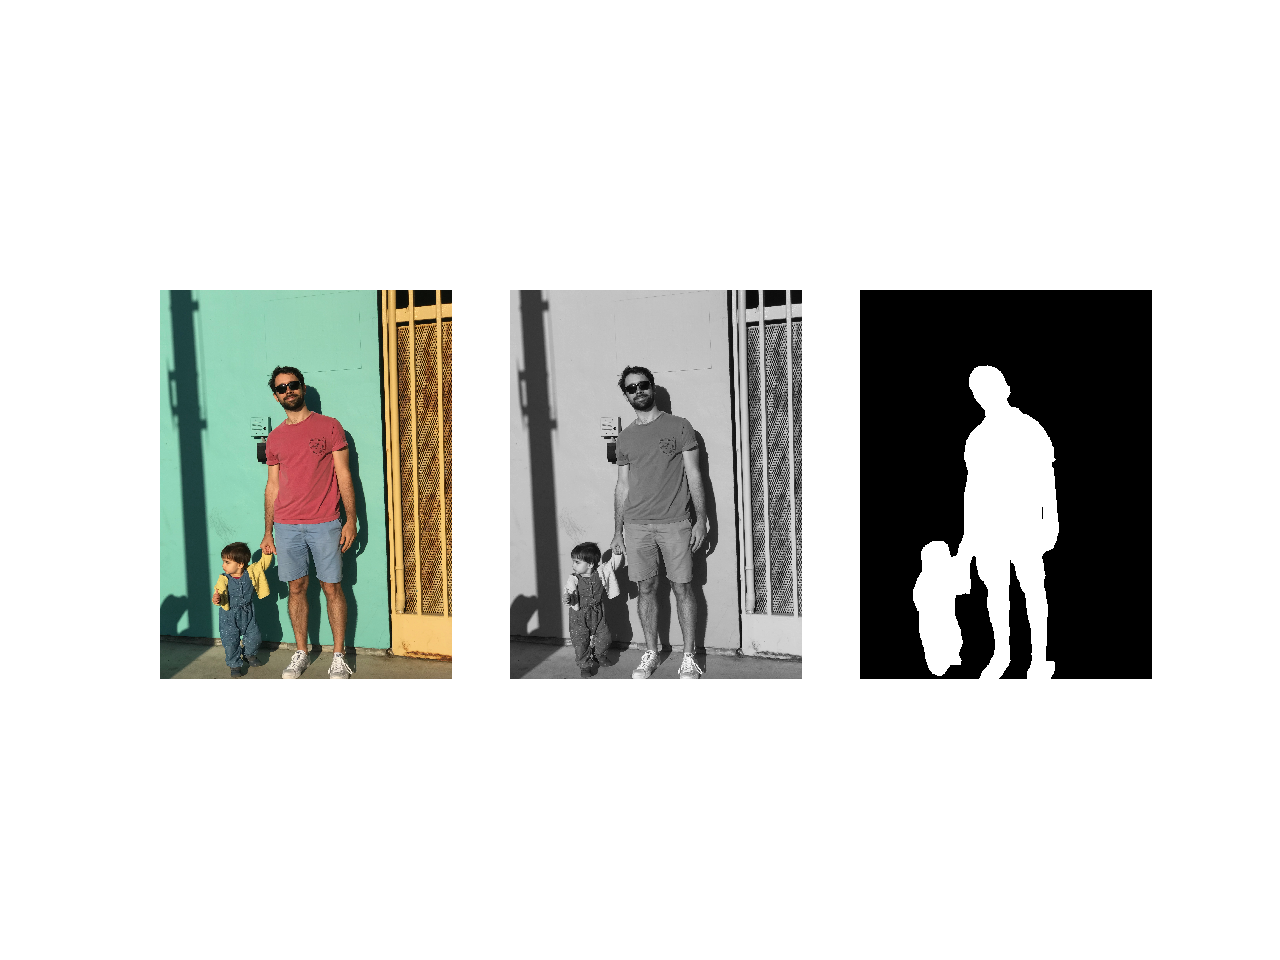

In [83]:
# Convert images into numpy arrays
img_rgb2 = np.array(img_rgb)
img_y2 = np.array(img_y)
pred2 = np.array(pred) / 12

# Specify the class label we are interested in
label = 'Person'

# List of labels
labels = ['Background','Plane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable','Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']
label2id = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}

# Compute the associated mask
mask = np.zeros(pred2.shape, dtype=np.uint8)
mask[pred2 == label2id[label]] = 1

# Plot
f, ax = plt.subplots(1,3)
ax[0].imshow(img_rgb2)
ax[1].imshow(img_y2, cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.show()

<IPython.core.display.Javascript object>


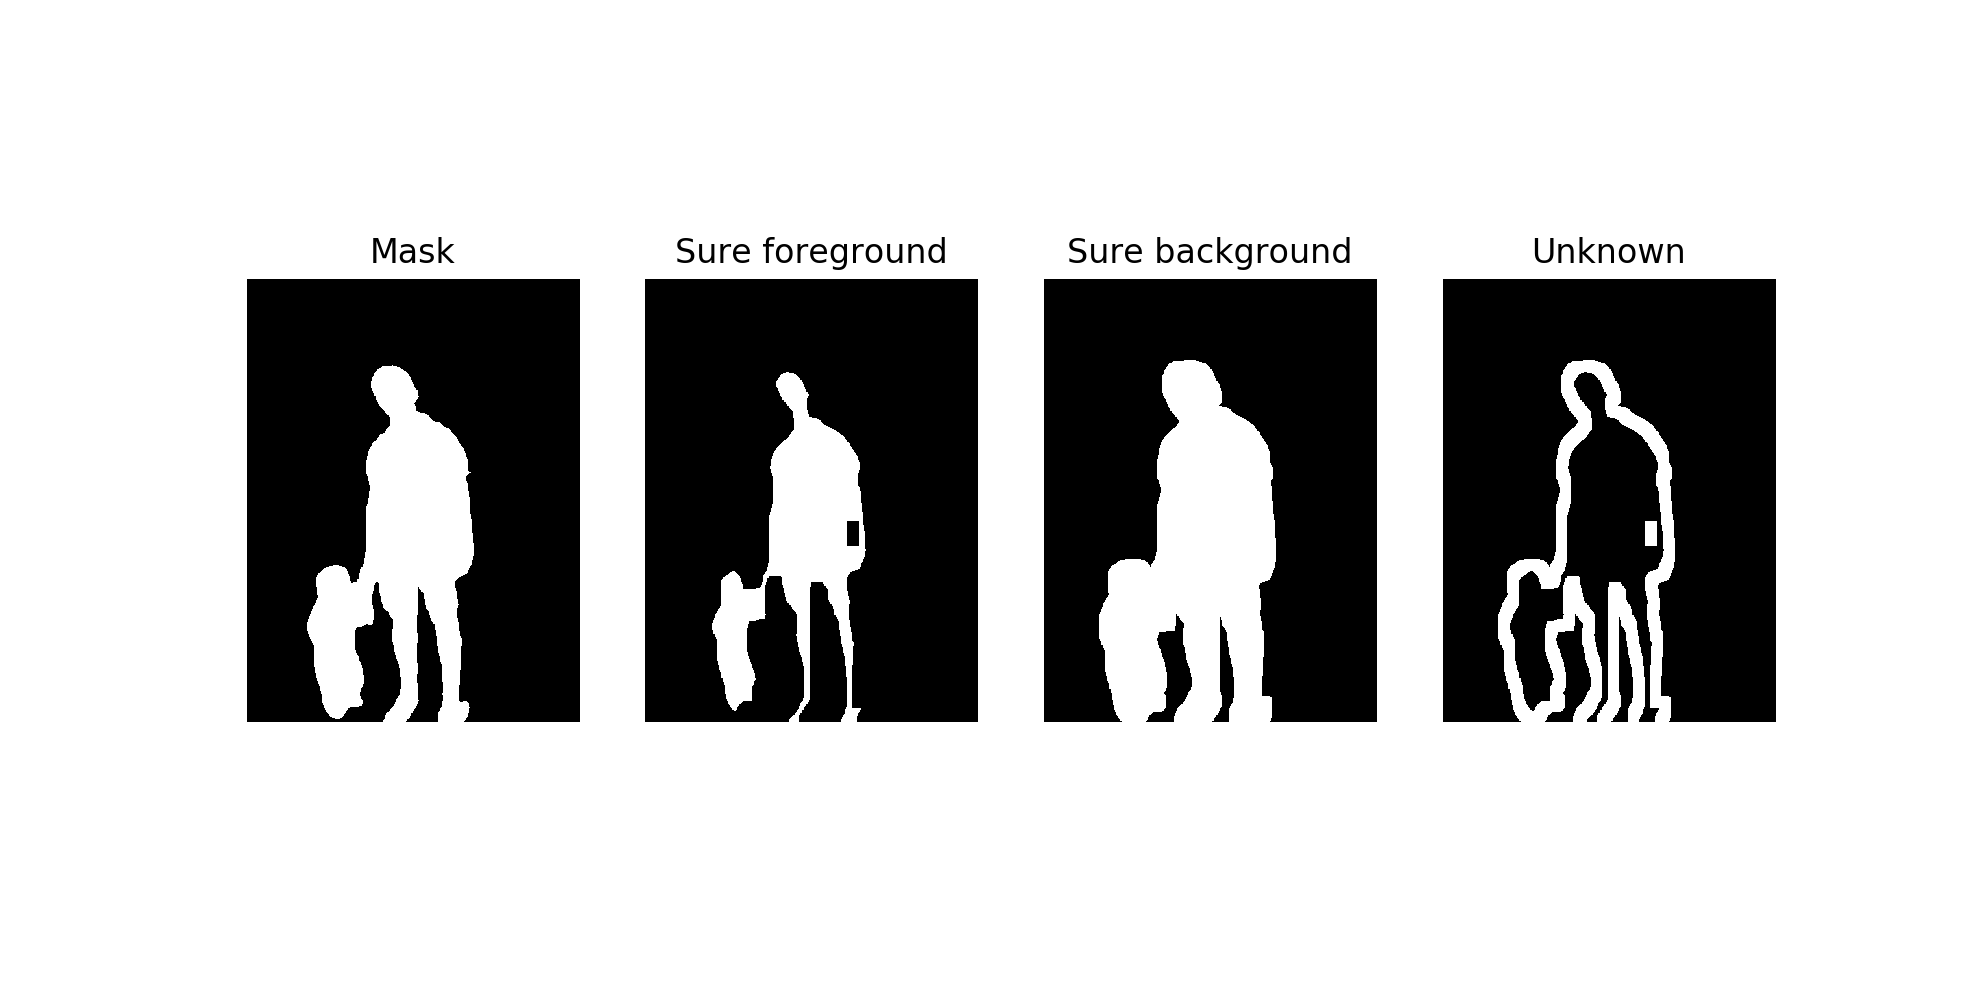

In [86]:
import cv2

# Element
kernel = np.ones((3,3),np.uint8)

# Sure foreground, background and unknown areas
sure_fg = cv2.erode(mask, kernel, iterations=50)
sure_bg = cv2.dilate(mask, kernel, iterations=50)
unknown = sure_bg - sure_fg

# Plot
f, ax = plt.subplots(1,4)
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(sure_fg, cmap='gray')
ax[2].imshow(sure_bg, cmap='gray')
ax[3].imshow(unknown, cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()
ax[0].set_title('Mask')
ax[1].set_title('Sure foreground')
ax[2].set_title('Sure background')
ax[3].set_title('Unknown')
plt.show()

<IPython.core.display.Javascript object>


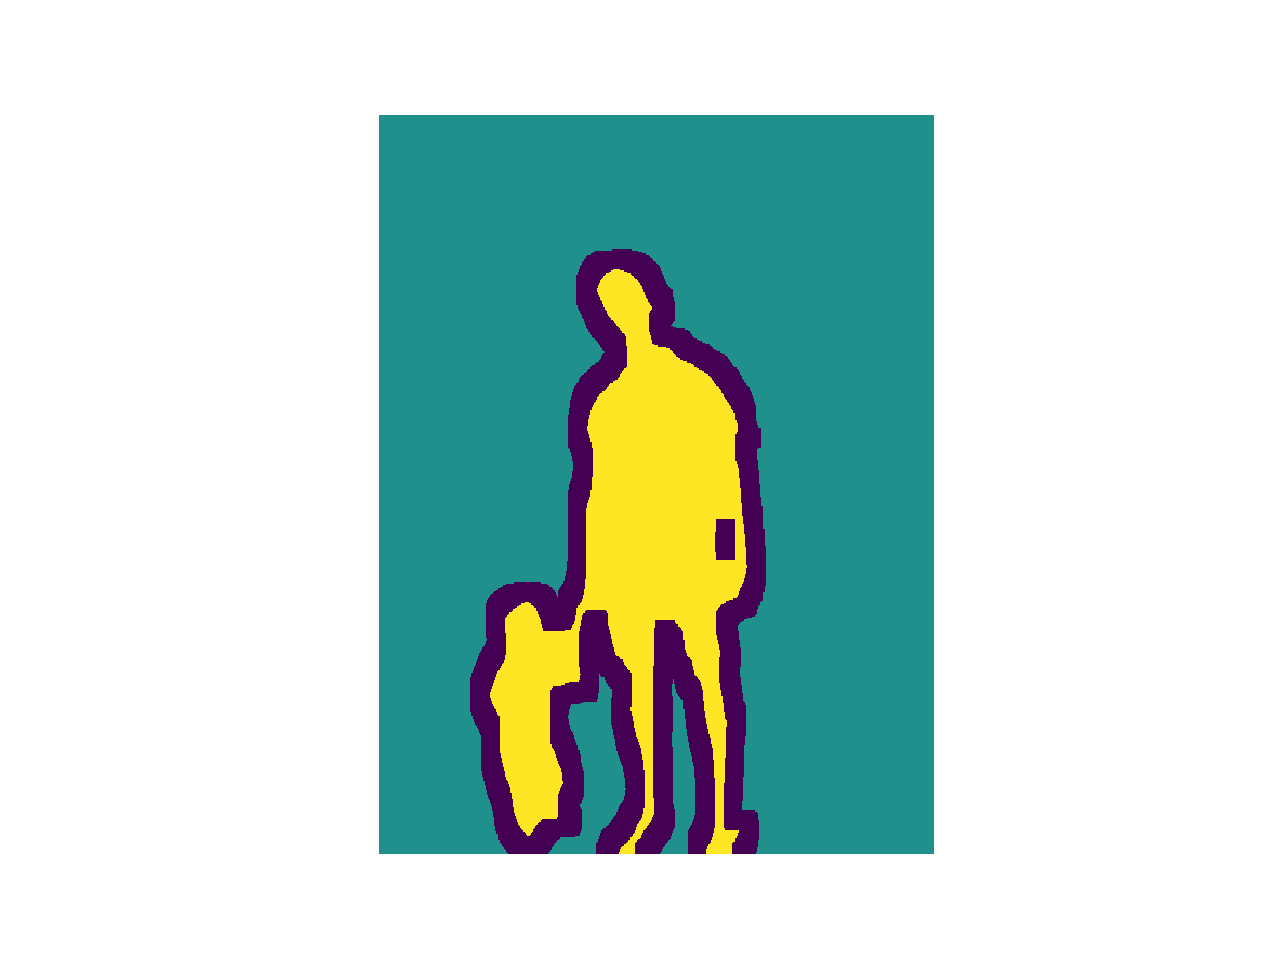

In [90]:
# Connected components
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==1] = 0

# Plot
plt.figure()
plt.imshow(markers)
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


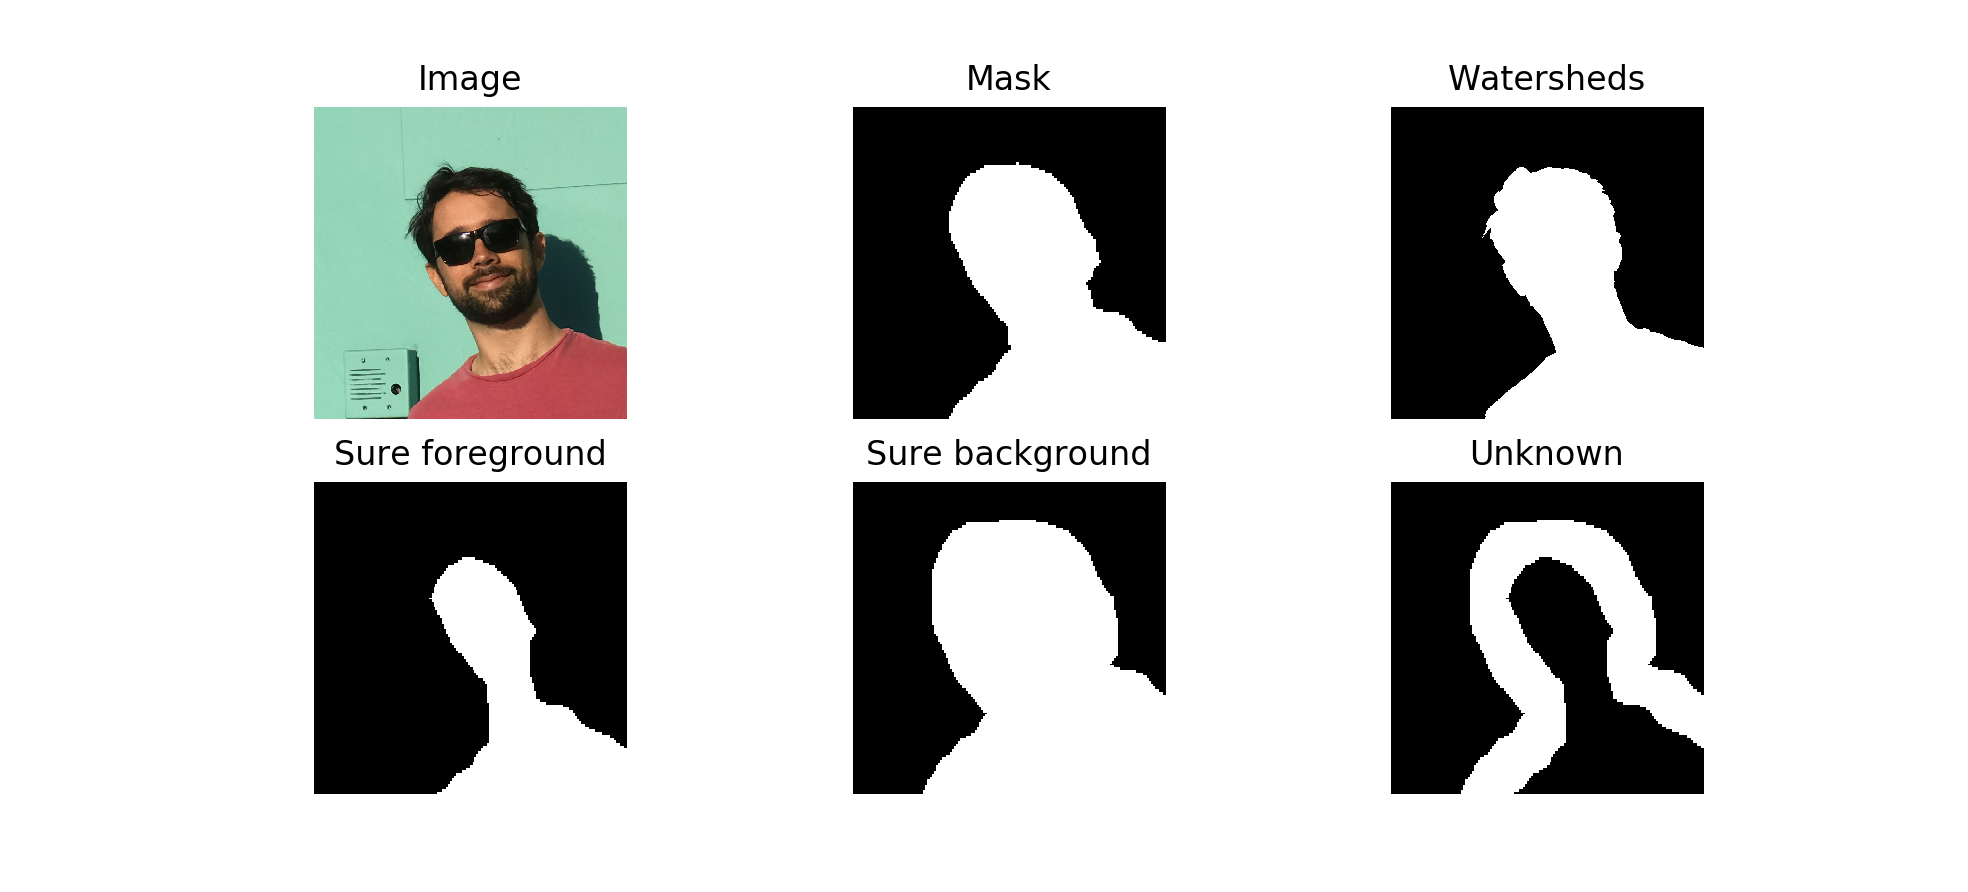

In [91]:
# Apply the watershed
markers2 = cv2.watershed(img_rgb2, markers)

# Keep only the foreground
markers3 = np.clip(markers2 - 1, 0, 255)

# Crop info
y = 625 # 2430
x = 850 # 416
h = 900
w = 900

# Plot
f, ax = plt.subplots(2,3)
ax[0,0].imshow(img_rgb2[y:y+h,x:x+w,:])
ax[0,1].imshow(mask[y:y+h,x:x+w], cmap='gray')
ax[0,2].imshow(markers3[y:y+h,x:x+w], cmap='gray')
ax[1,0].imshow(sure_fg[y:y+h,x:x+w], cmap='gray')
ax[1,1].imshow(sure_bg[y:y+h,x:x+w], cmap='gray')
ax[1,2].imshow(unknown[y:y+h,x:x+w], cmap='gray')
ax[0,0].set_title('Image')
ax[0,1].set_title('Mask')
ax[0,2].set_title('Watersheds')
ax[1,0].set_title('Sure foreground')
ax[1,1].set_title('Sure background')
ax[1,2].set_title('Unknown')
for i in range(ax.size):
    ax.flatten()[i].set_axis_off()
plt.show()